In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import seaborn as sns
    sns.set_style("ticks") 
    #sns.set_style({"axes.axisbelow": False})
    sns.set_style({"xtick.direction": "in" ,"ytick.direction": "in"})
except:
    print("sns problem")

from scipy import signal


In [3]:
def read_file(f="Run59775_Ch27"):
    df = pd.read_csv(f, sep=r"\s+", header=None, names=["pedvar", "dpedvar"])
    return df

df_test = read_file(f="Run59775_Ch27")


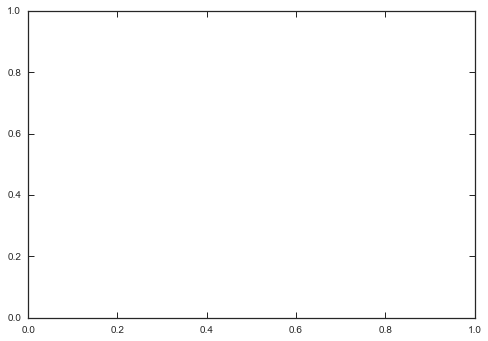

In [100]:
def plot_df(df, t=None, fig=plt.figure(), ax=plt.subplot(111), 
            xlabel="Bin number", ylabel="Pedestal variance", 
            xlim=None, ylim=None, label="Run59775_Ch27"):
    fig=fig 
    ax=ax
    if t is None:
        ax.errorbar(range(df.shape[0]), df.pedvar, yerr=df.dpedvar, label=label)
    else:
        ax.errorbar(t, df.pedvar, yerr=df.dpedvar, label=label)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    #plt.show()
    
#plot_df(df_test, label="Run59775_Ch27")


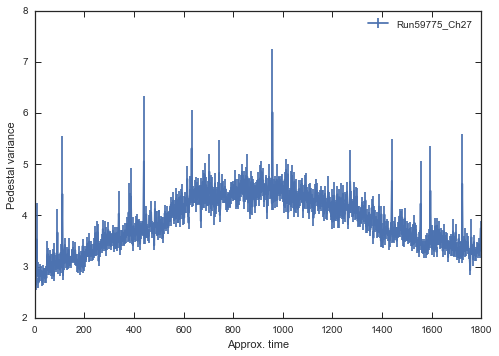

In [101]:
t = np.linspace(0, 30.*60., df_test.shape[0], endpoint=False)

plot_df(df_test, t=t, fig=plt.figure(), ax=plt.subplot(111), xlabel="Approx. time", label="Run59775_Ch27")



# Morlet wavelet

//anaconda/envs/obspy/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


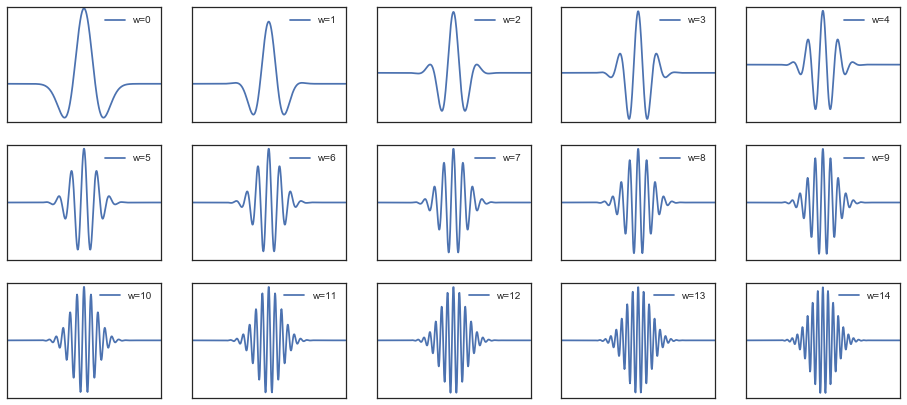

In [7]:
fig, ax = plt.subplots(3, 5, figsize=(16,7))
for i in range(15):
    mw=signal.morlet(500, w=i+1, s=1.0, complete=True)
    ax_ = ax[i/5, i%5]
    ax_.plot(mw, label="w={}".format(i))
    ax_.set_xticks([])
    ax_.set_yticks([])
    ax_.legend()


    


# CWT

In [102]:
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

#cwt(st, dt, w0, fmin, fmax, nf=100, wl='morlet'):
"""
    Continuous Wavelet Transformation in the Frequency Domain.
    .. seealso:: [Kristekova2006]_, eq. (4)
    :param st: time dependent signal.
    :param dt: time step between two samples in st (in seconds)
    :param w0: parameter for the wavelet, tradeoff between time and frequency
        resolution
    :param fmin: minimum frequency (in Hz)
    :param fmax: maximum frequency (in Hz)
    :param nf: number of logarithmically spaced frequencies between fmin and
        fmax
    :param wl: wavelet to use, for now only 'morlet' is implemented
    :return: time frequency representation of st, type numpy.ndarray of complex
        values, shape = (nf, len(st)).
"""
    
    
def plot_cwt(t, sig, dt=None, plot_series=True, w0=8, df_pedvar=None, 
             nf=None, label="", cmap='viridis', f_min=None, f_max=None, 
             xlabel="Time [s]"):
    if dt is None:
        dt = t[1] - t[0]
    if plot_series:
        fig, ax = plt.subplots(2, 1, figsize=(10,16))
        if df_pedvar is not None:
            plot_df(df_pedvar, t=t, fig=fig, ax=ax[0], xlabel=xlabel, label=label)
        else:
            ax[0].plot(t, sig)
            #plt.show()

    freq = np.logspace(np.log10(1./(t[-1]-t[0])), np.log10(1./(t[1]-t[0])/2.), (t[-1]-t[0])*1./(t[1]-t[0])/2.)
    if nf is None:
        nf = freq.shape[0]
    if f_min is None:
        f_min = freq[0]
    if f_max is None:
        f_max = freq[-1]


    scalogram = cwt(sig, dt, w0, f_min, f_max, nf=nf, wl='morlet')
    
    if plot_series:
        ax_scalo = ax[1]
    else:
        fig = plt.figure()
        ax_scalo = fig.add_subplot(111)

    x, y = np.meshgrid(
        t,
        np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

    ax_scalo.pcolormesh(x, y, np.abs(scalogram), cmap=cmap)
    ax_scalo.set_xlabel(xlabel)
    ax_scalo.set_ylabel("Frequency [Hz]")
    ax_scalo.set_yscale('log')
    ax_scalo.set_ylim(f_min, f_max)
    plt.show()




# Scipy cwt with ricker wavelet, doesn't quite work out of the box

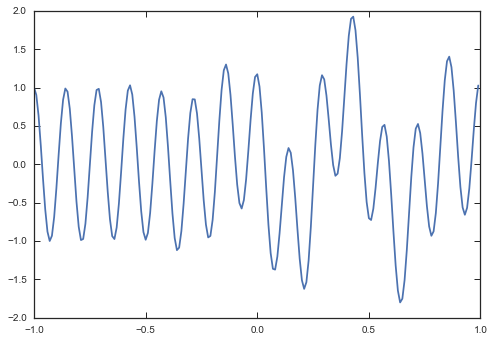

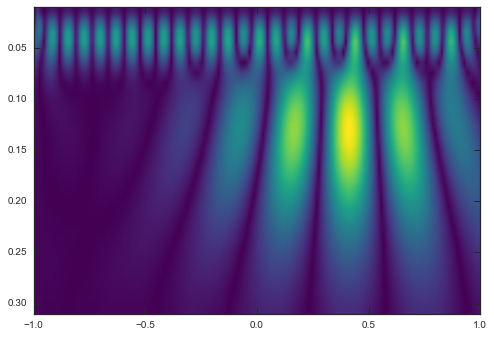

In [86]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
plt.plot(t, sig)
plt.show()

widths = np.arange(1, 31)
cwtmatr = signal.cwt(sig, signal.ricker, widths)

plt.imshow(abs(cwtmatr), extent=[-1, 1,  31*dt, 1*dt], cmap='viridis', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=0)
plt.show()




# obspy works out of the box 

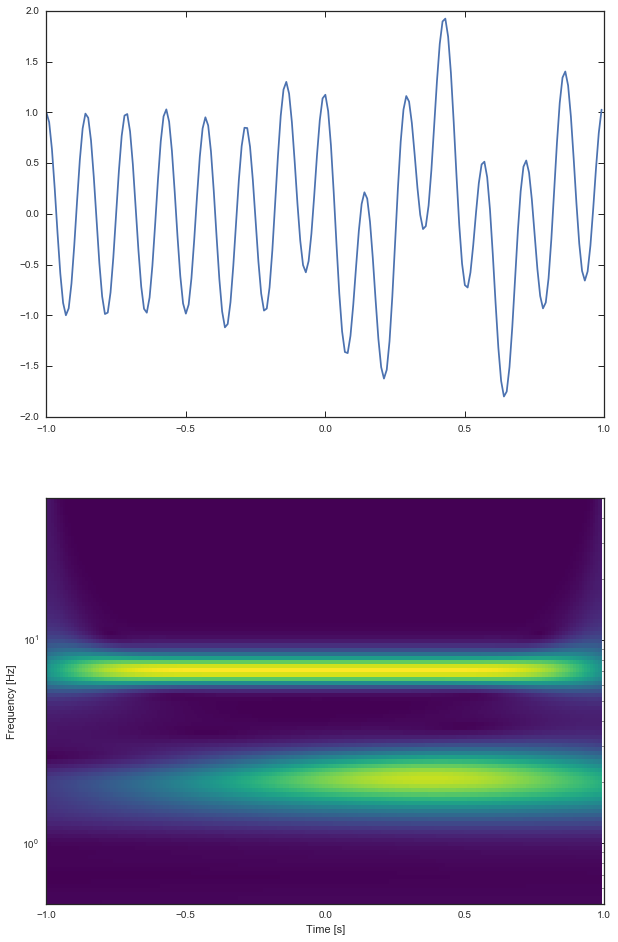

In [103]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)

plot_cwt(t, sig, dt=None, plot_series=True, w0=8)


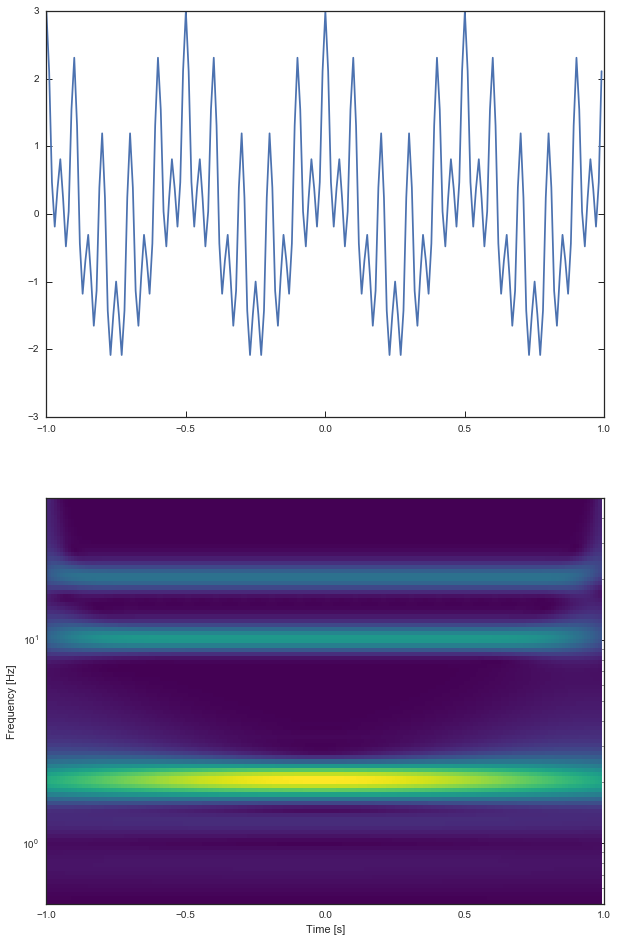

In [91]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 10 * t) + np.cos(2 * np.pi * 80 * t) + np.cos(2 * np.pi * 2 * t)

plot_cwt(t, sig, dt=None, plot_series=True, w0=9, cmap='viridis')




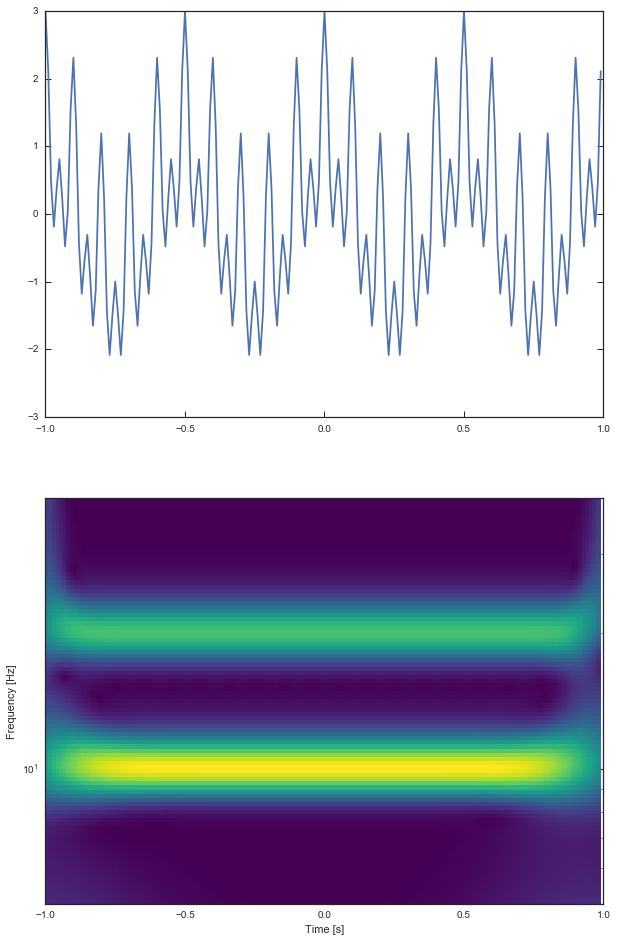

In [92]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 10 * t) + np.cos(2 * np.pi * 80 * t) + np.cos(2 * np.pi * 2 * t)

plot_cwt(t, sig, nf=100, dt=None, f_min=5, f_max=40, plot_series=True, w0=9, cmap='viridis')



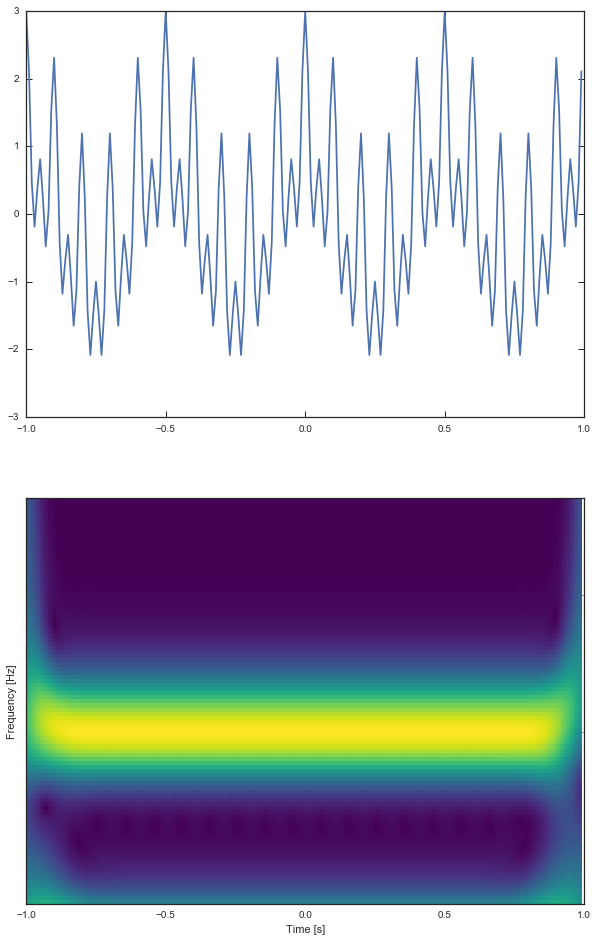

In [93]:
plot_cwt(t, sig, nf=100, dt=None, f_min=12, f_max=40, plot_series=True, w0=9, cmap='viridis')



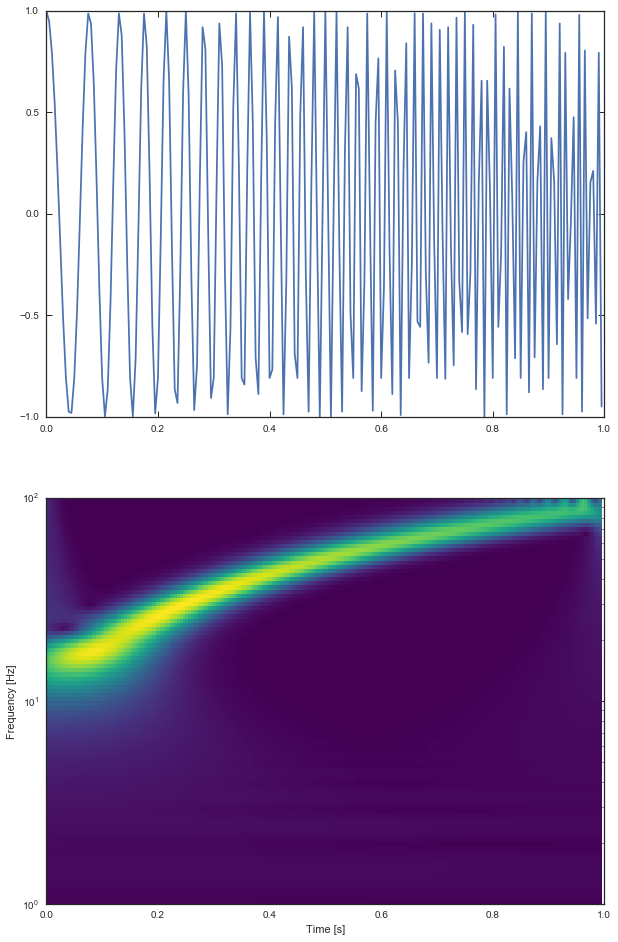

In [94]:
t = np.linspace(0, 1, 200, endpoint=False)
dt = t[1] - t[0]
#sig  = np.cos(2 * np.pi * 10 * t) + signal.gausspulse(t - 0.4, fc=2)
sig = signal.chirp(t, 10, 0.5, 50, method='linear', phi=0, vertex_zero=True)

plot_cwt(t, sig, dt=None, plot_series=True, w0=8, cmap='viridis')



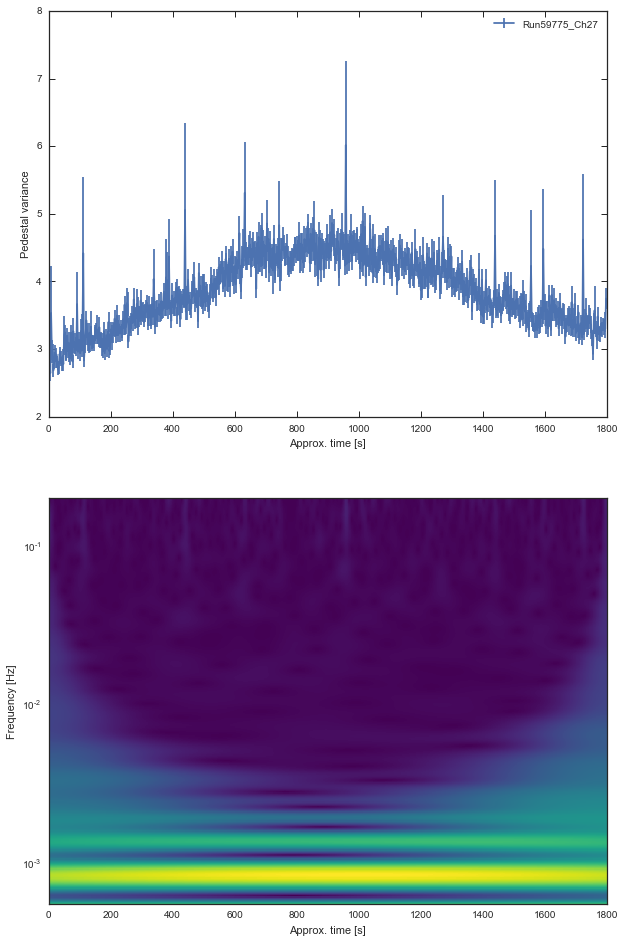

In [104]:
t = np.linspace(0, 30.*60., df_test.shape[0], endpoint=False)
plot_cwt(t, df_test.pedvar, dt=None, plot_series=True, w0=8, df_pedvar=df_test, 
         xlabel="Approx. time [s]", label="Run59775_Ch27", cmap='viridis')



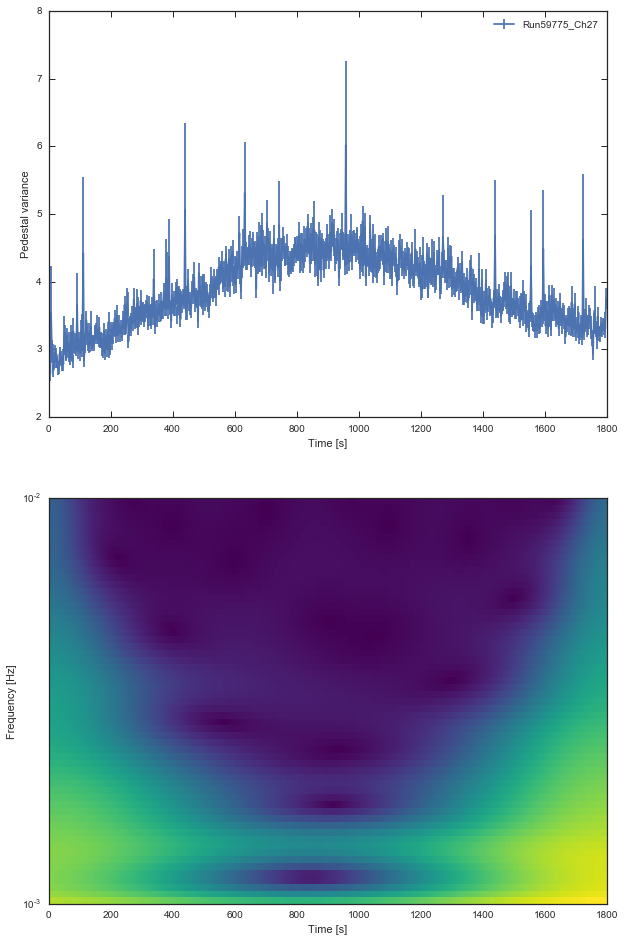

In [105]:
t = np.linspace(0, 30.*60., df_test.shape[0], endpoint=False)
plot_cwt(t, df_test.pedvar, nf=60, dt=None, plot_series=True, w0=5, 
         f_min=1e-3, f_max=1e-2, 
         df_pedvar=df_test, label="Run59775_Ch27", cmap='viridis')



# Highlight high frequencies

2.46913580247


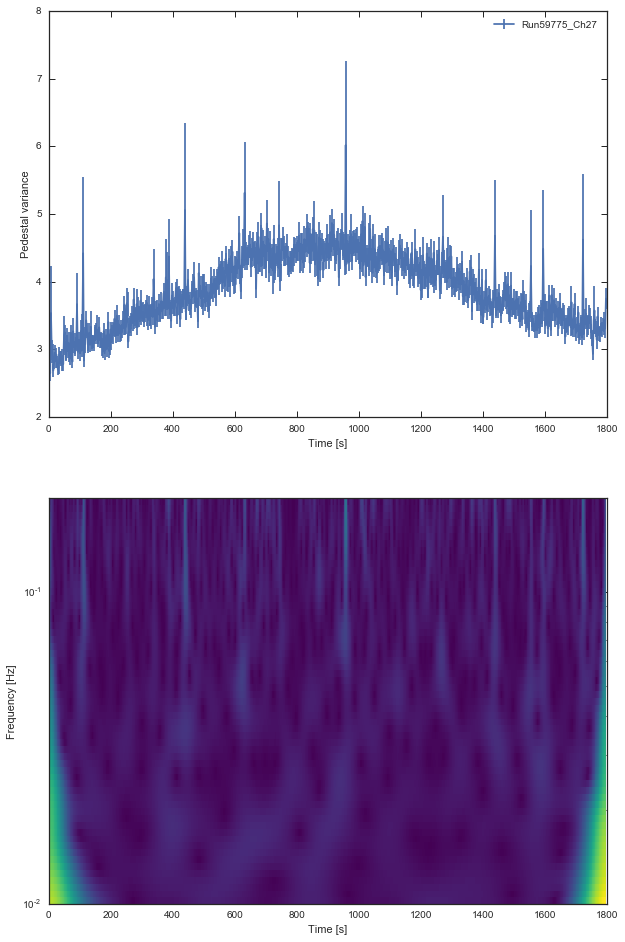

In [106]:
t = np.linspace(0, 30.*60., df_test.shape[0], endpoint=False)
print(t[1]-t[0])
plot_cwt(t, df_test.pedvar, nf=60, dt=None, plot_series=True, w0=5, 
         f_min=1e-2, f_max=0.2, 
         df_pedvar=df_test, label="Run59775_Ch27", cmap='viridis')



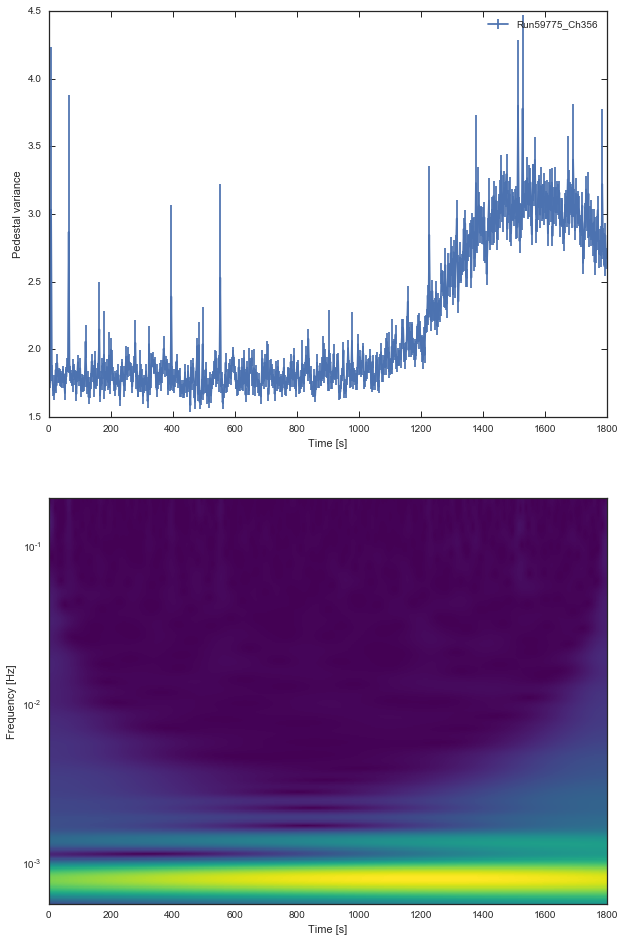

In [108]:
df1 = read_file(f="Run59775_Ch356")
t = np.linspace(0, 30.*60., df1.shape[0], endpoint=False)

plot_cwt(t, df1.pedvar, dt=None, plot_series=True, w0=8, df_pedvar=df1, label="Run59775_Ch356")





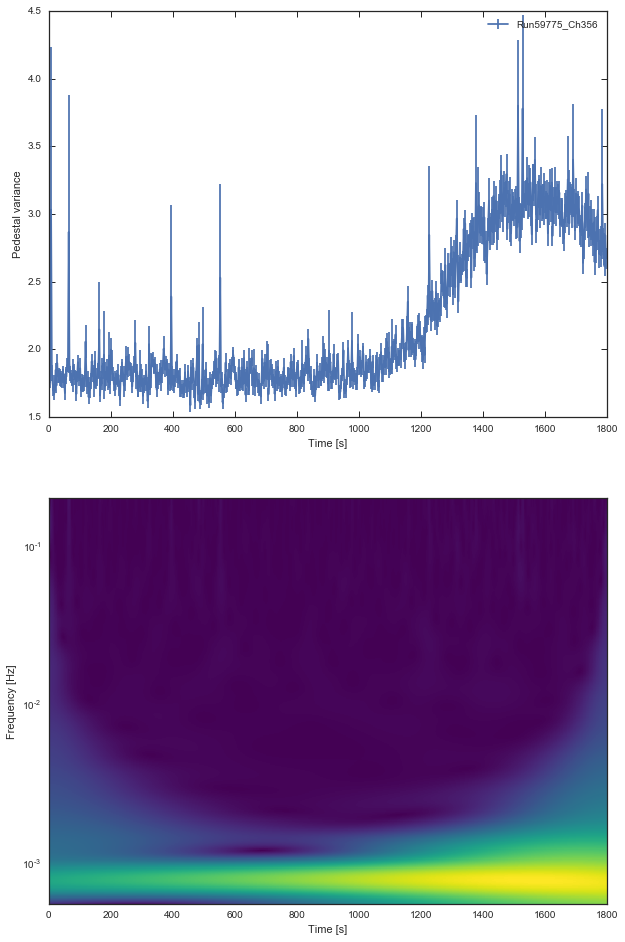

In [109]:
#df1 = read_file(f="Run59775_Ch356")
plot_cwt(t, df1.pedvar, dt=None, plot_series=True, w0=np.sqrt(2)*np.pi, df_pedvar=df1, label="Run59775_Ch356")



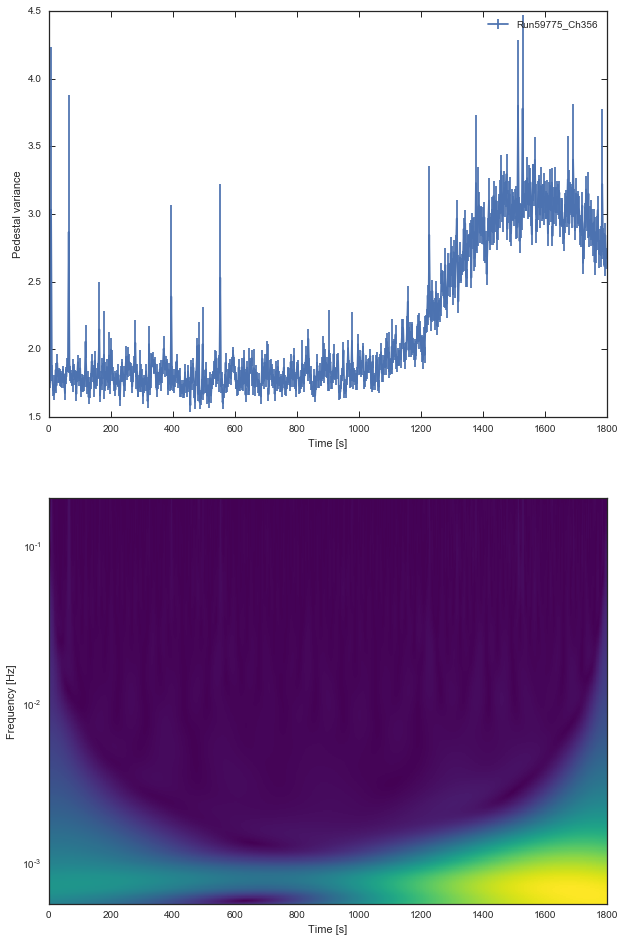

In [110]:
plot_cwt(t, df1.pedvar, dt=None, plot_series=True, w0=3, df_pedvar=df1, label="Run59775_Ch356")



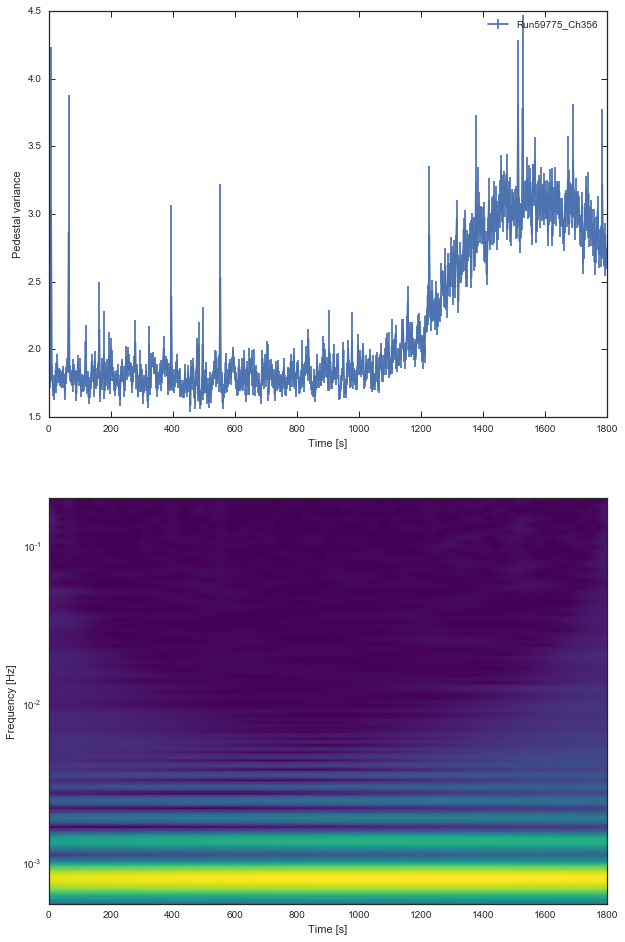

In [111]:
plot_cwt(t, df1.pedvar, dt=None, plot_series=True, w0=20, df_pedvar=df1, label="Run59775_Ch356")



# Highlight high frequencies

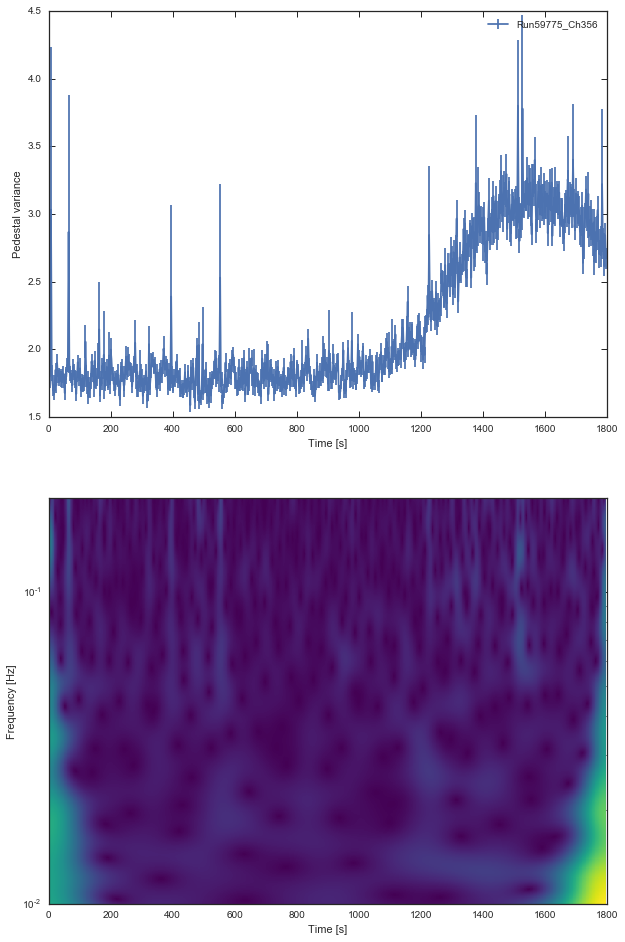

In [112]:
df1 = read_file(f="Run59775_Ch356")
t = np.linspace(0, 30.*60., df1.shape[0], endpoint=False)

plot_cwt(t, df1.pedvar, dt=None, plot_series=True, w0=8, 
         f_min=1e-2, f_max=0.2, 
         df_pedvar=df1, label="Run59775_Ch356")




